This is a notebook to benchmark the classification performance of the HBM from [1] against HM4.

[1] Plebani, E., Ehlmann, B. L., Leask, E. K., Fox, V. K., & Dundar, M. M. (2022). 
A machine learning toolkit for CRISM image analysis. Icarus, 376, 114849. https://doi.org/10.1016/j.icarus.2021.114849


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from expected_cost.ec import average_cost, CostMatrix
import torch
from torchmetrics.classification.calibration_error import MulticlassCalibrationError
from torchmetrics.functional.classification.calibration_error import _binning_bucketize


from crism_ml.lab import relabel, ALIASES_TRAIN, CLASS_NAMES
from crism_ml.preprocessing import remove_spikes
from crism_ml.train import (
    train_model,
    iteration_weights,
    feat_masks,
    compute_scores,
    filter_predictions,
)

from n2n4m.preprocessing import load_dataset
import crism_classifier.labelling as labelling
from crism_classifier.labelling import CLASS_NAMES as RP_CLASS_NAMES
from crism_classifier.expected_cost import COST_ARRAY

In [ ]:
RATIOED_TEST_SET_PATH = # Insert the path to the ratioed test set here
RATIOED_HOLDOUT_SET_PATH = # Insert the path to the ratioed holdout set here
CRISM_ML_DIR_PATH = # Insert the path to the crism-ml directory here. Data can be found here https://zenodo.org/records/13338091

In [ ]:
data = load_dataset(RATIOED_TEST_SET_PATH)

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/

In [ ]:
fin0, fin = feat_masks()
models = train_model(CRISM_ML_DIR_PATH, fin) # Note this is using the full dataset including the test data
weights = iteration_weights(models[0].classes)

In [8]:
test_spectra = data.drop(columns=["Pixel_Class", "Coordinates", "Image_Name"]).values
test_spectra = test_spectra[:, :248] # Number and same bands the Plebani model uses. 

In [9]:
test_labels = data["Pixel_Class"].values

In [10]:
len(np.unique(test_labels))

37

In [11]:
# check if there are any Artefact (class 38)
test_labels[test_labels == 38].shape

(0,)

In [12]:
despiked_spectra = remove_spikes(test_spectra)  # Final despike
scores = compute_scores(despiked_spectra, (models, fin), weights)

In [13]:
filtered_preds, preds, pred_probs = filter_predictions(
    scores, models[0].classes, merge_clays=False, kls_thr=(0.5, 0.7)
)

In [14]:
def get_classification_report(predictions, labels, class_labels):
    """
    Function to generate a classification report for a set of predictions.
    Parameters
    ----------
    predictions: np.ndarray
        Predicted class labels. Shape (n_samples,).
    labels: np.ndarray
        True class labels. Shape (n_samples,).

    Returns
    -------
    report: dict
        Sklearn classification report.
    """
    true_unique_classes = np.unique(labels)
    predicted_unique_classes = np.unique(predictions)
    classes_to_calculate_f1 = np.unique(np.concatenate((true_unique_classes, predicted_unique_classes)))
    string_classes = np.array([class_labels[obs_class] for obs_class in classes_to_calculate_f1])

    report = classification_report(labels, predictions, target_names=string_classes, zero_division=0, output_dict=True)
    return report

In [15]:
cost_matrix = CostMatrix(COST_ARRAY)
priors = np.full(38, 1/38) # Uniform priors

First classification report and confusion matrix using all the class labels i.e. the finest precision possible - even though the classifier isn't designed for this.

In [16]:
filter_mask = np.ma.masked_where(filtered_preds !=0, filtered_preds)
filtered_preds = filtered_preds[filter_mask.mask]
filtered_test_labels = test_labels[filter_mask.mask]

In [17]:
preds_zero_indexed = labelling.make_array_zero_indexed(preds, forwards=True)
filtered_preds_zero_indexed = labelling.make_array_zero_indexed(filtered_preds, forwards=True)

In [18]:
report = get_classification_report(preds_zero_indexed, test_labels, RP_CLASS_NAMES)
filtered_report = get_classification_report(filtered_preds_zero_indexed, filtered_test_labels, RP_CLASS_NAMES)

In [19]:
expected_cost = average_cost(preds_zero_indexed, test_labels, cost_matrix, priors)
filtered_expected_cost = average_cost(filtered_preds_zero_indexed, filtered_test_labels, cost_matrix, priors)

In [20]:
print("For base predictions:")
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {expected_cost}")
print("For filtered predictions:")
print(f"Accuracy: {filtered_report['accuracy']}")
print(f"Macro F1: {filtered_report['macro avg']['f1-score']}")
print(f"Weighted F1: {filtered_report['weighted avg']['f1-score']}")
print(f"Precision: {filtered_report['macro avg']['precision']}")
print(f"Recall: {filtered_report['macro avg']['recall']}")
print(f"Expected Cost: {filtered_expected_cost}")

For base predictions:
Accuracy: 0.7180524031897594
Macro F1: 0.48981758426441807
Weighted F1: 0.7171686171671752
Precision: 0.473509805121279
Recall: 0.5898592288465043
Expected Cost: 0.404432121364257
For filtered predictions:
Accuracy: 0.8394532197005017
Macro F1: 0.6099602773385504
Weighted F1: 0.8167196423598926
Precision: 0.6258533814314773
Recall: 0.6688867385902622
Expected Cost: 0.07713806119085187


In [21]:
unique_labels = np.unique(np.concatenate((np.unique(test_labels), np.unique(preds_zero_indexed))))
string_labels = [RP_CLASS_NAMES[obs_class] for obs_class in unique_labels]

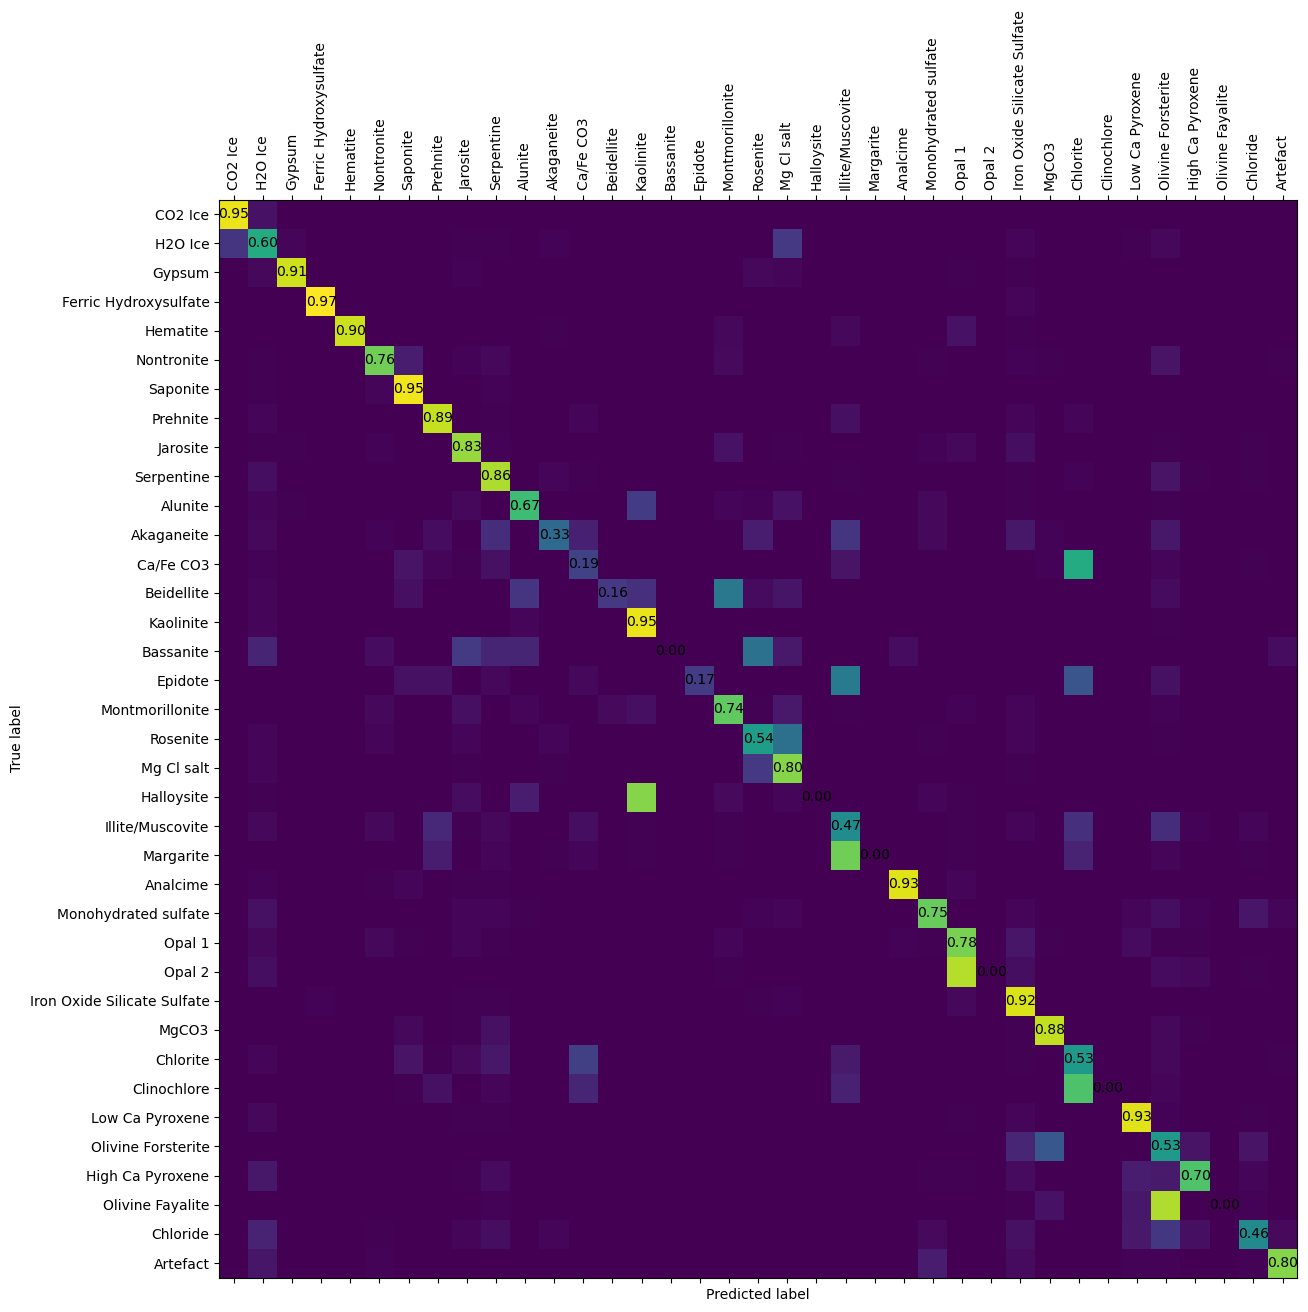

In [22]:
cm = confusion_matrix(test_labels, preds_zero_indexed, normalize="true")

fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm)
# axes labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticks(range(len(string_labels)), string_labels, rotation=90)
ax.set_yticks(range(len(string_labels)), string_labels)
for i in range(len(string_labels)):
    for j in range(len(string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

Second time around, using only the classes the model was trained on (i.e. mapping some of the precise classes to broader labels)

In [23]:
# need to change the test_labels to match the plebani scheme if I want to use their relabelling.
test_labels_relabelled = labelling.change_pixel_label(test_labels.copy(), in_val=21, out_val=38)
test_labels_relabelled = labelling.make_array_zero_indexed(test_labels_relabelled, forwards=False)

In [24]:
test_labels_relabelled = relabel(test_labels_relabelled, ALIASES_TRAIN)
filtered_test_labels_relabelled = test_labels_relabelled[filter_mask.mask]

In [25]:
report = get_classification_report(preds, test_labels_relabelled, CLASS_NAMES)
filtered_report = get_classification_report(filtered_preds, filtered_test_labels_relabelled, CLASS_NAMES)

In [26]:
test_labels_relabelled_zero_indexed = labelling.make_array_zero_indexed(test_labels_relabelled, forwards=True)
preds_zero_indexed = labelling.make_array_zero_indexed(preds, forwards=True)

In [27]:
super_class_expected_cost = average_cost(test_labels_relabelled_zero_indexed, preds_zero_indexed, cost_matrix, priors)

In [28]:
print("For base predictions:")
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {super_class_expected_cost}")
print("For filtered predictions:")
print(f"Accuracy: {filtered_report['accuracy']}")
print(f"Macro F1: {filtered_report['macro avg']['f1-score']}")
print(f"Weighted F1: {filtered_report['weighted avg']['f1-score']}")
print(f"Precision: {filtered_report['macro avg']['precision']}")
print(f"Recall: {filtered_report['macro avg']['recall']}")

For base predictions:
Accuracy: 0.7933265503117581
Macro F1: 0.6033321703815637
Weighted F1: 0.8107836433329556
Precision: 0.5912857455269571
Recall: 0.691579664852103
Expected Cost: 0.290898085592485
For filtered predictions:
Accuracy: 0.9383846483784943
Macro F1: 0.7770399354821952
Weighted F1: 0.935115640858362
Precision: 0.8056355835287409
Recall: 0.7810615730812386


In [29]:
unique_labels = np.unique(np.concatenate((np.unique(test_labels_relabelled), np.unique(preds))))
relabelled_string_labels = [CLASS_NAMES[obs_class] for obs_class in unique_labels]

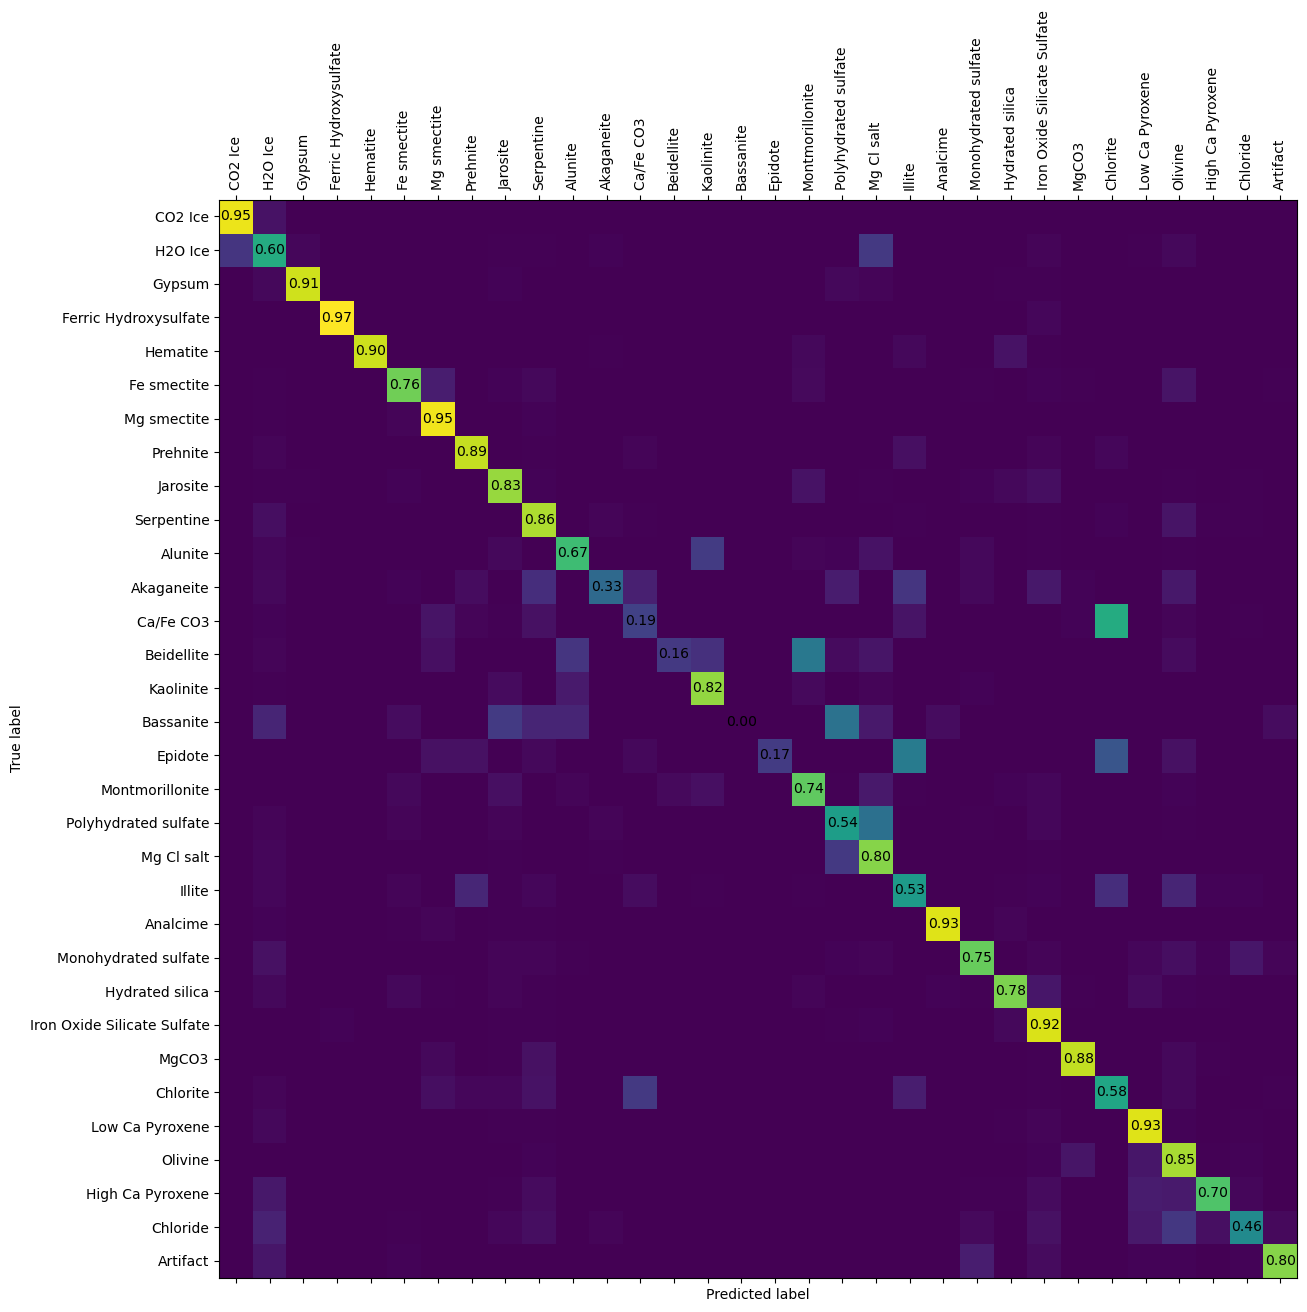

In [30]:
cm = confusion_matrix(test_labels_relabelled, preds, normalize="true")

fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm)
# axes labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticks(range(len(relabelled_string_labels)), relabelled_string_labels, rotation=90)
ax.set_yticks(range(len(relabelled_string_labels)), relabelled_string_labels)
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(relabelled_string_labels)):
    for j in range(len(relabelled_string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")
plt.show()

In [31]:
# np.save("HBM_confusion_matrix.npy", cm)

Calibration

In [32]:
accuracies = preds == test_labels_relabelled
accuracies = torch.tensor(accuracies)
bin_bounds = torch.linspace(0, 1, 11) # ten bins
pred_probs = torch.tensor(pred_probs)
acc_bin, conf_bin, prop_bin = _binning_bucketize(pred_probs, accuracies, bin_bounds) # bucketize the probs/confs, the accuracies, and the proportion of data in each bin
# acc_bin gives the accuracy for each bin, conf_bin is the average confidence of the bin, and prop_bin is the proportion of data in each bin

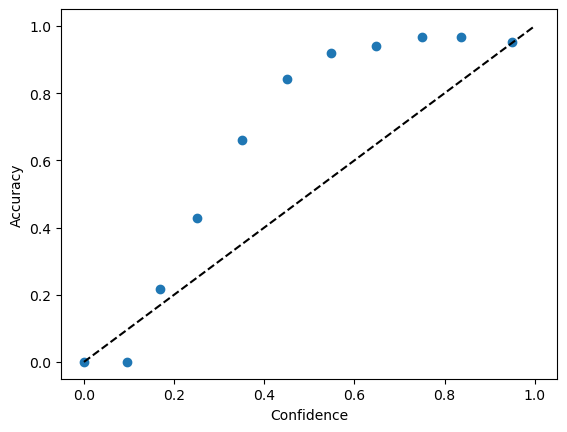

In [33]:
fig, ax = plt.subplots()
ax.scatter(conf_bin, acc_bin)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
# add a diagonal line for reference
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

In [34]:
conf_bin

tensor([0.0952, 0.1681, 0.2511, 0.3507, 0.4506, 0.5480, 0.6484, 0.7487, 0.8362,
        0.9490, 0.0000], dtype=torch.float64)

In [39]:
print(f"Mean confidnece: {pred_probs.mean()}, minimum confidence {pred_probs.min()}, maximum confidence {pred_probs.max()}")

Mean confidnece: 0.5162484972831549, minimum confidence 0.07869013596023615, maximum confidence 0.9999955378958921


In [40]:
scores = torch.tensor(scores)
test_labels_relabelled = torch.tensor(test_labels_relabelled)

In [41]:
calibration_metric = MulticlassCalibrationError(num_classes=32, n_bins=10)
calibration_metric.update(scores, test_labels_relabelled)
ece = calibration_metric.compute()
print(f"ECE: {ece}")

ECE: 0.4794631898403168


Now look at the prediction capabilites on the holdout images

In [ ]:
holdout_data = load_dataset(RATIOED_HOLDOUT_SET_PATH)
holdout_spectra = holdout_data.drop(columns=["Pixel_Class", "Coordinates", "Image_Name"]).values
holdout_spectra = holdout_spectra[:, :248]
holdout_labels = holdout_data["Pixel_Class"].values

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/

In [43]:
despiked_holdout_spectra = remove_spikes(holdout_spectra)  # Final despike
holdout_scores = compute_scores(despiked_holdout_spectra, (models, fin), weights)

In [44]:
filtered_preds, preds, pred_probs = filter_predictions(
    holdout_scores, models[0].classes, merge_clays=False, kls_thr=(0.5, 0.7)
)

In [45]:
filter_mask = np.ma.masked_where(filtered_preds !=0, filtered_preds)
filtered_preds = filtered_preds[filter_mask.mask]
filtered_holdout_labels = holdout_labels[filter_mask.mask]

In [46]:
preds_zero_indexed = labelling.make_array_zero_indexed(preds, forwards=True)

filtered_preds_zero_indexed = labelling.make_array_zero_indexed(filtered_preds, forwards=True)

In [47]:
report = get_classification_report(preds_zero_indexed, holdout_labels, RP_CLASS_NAMES)
filtered_report = get_classification_report(filtered_preds_zero_indexed, filtered_holdout_labels, RP_CLASS_NAMES)

In [48]:
expected_cost = average_cost(preds_zero_indexed, holdout_labels, cost_matrix, priors)
filtered_expected_cost = average_cost(filtered_preds_zero_indexed, filtered_holdout_labels, cost_matrix, priors)

In [49]:
print("For base predictions:")
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {expected_cost}")
print("For filtered predictions:")
print(f"Accuracy: {filtered_report['accuracy']}")
print(f"Macro F1: {filtered_report['macro avg']['f1-score']}")
print(f"Weighted F1: {filtered_report['weighted avg']['f1-score']}")
print(f"Precision: {filtered_report['macro avg']['precision']}")
print(f"Recall: {filtered_report['macro avg']['recall']}")
print(f"Expected Cost: {filtered_expected_cost}")

For base predictions:
Accuracy: 0.5318988297470744
Macro F1: 0.14287097414574093
Weighted F1: 0.5927007301582717
Precision: 0.1580401216474578
Recall: 0.1363008562917852
Expected Cost: 0.8050072305168989
For filtered predictions:
Accuracy: 0.6797059922760683
Macro F1: 0.3735711627940253
Weighted F1: 0.6843946940403041
Precision: 0.4030680717260007
Recall: 0.3674490124473265
Expected Cost: 0.13435579758943147


In [50]:
unique_labels = np.unique(np.concatenate((np.unique(holdout_labels), np.unique(preds_zero_indexed))))
string_labels = [RP_CLASS_NAMES[obs_class] for obs_class in unique_labels]

In [51]:
np.unique(holdout_labels)

array([ 5,  6,  8, 11, 12, 17, 22, 23, 29, 31])

In [52]:
np.unique(preds_zero_indexed)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       18, 19, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37])

In [53]:
# count number of 0's in pred_zero_indexed
(preds_zero_indexed == 1).sum()

134

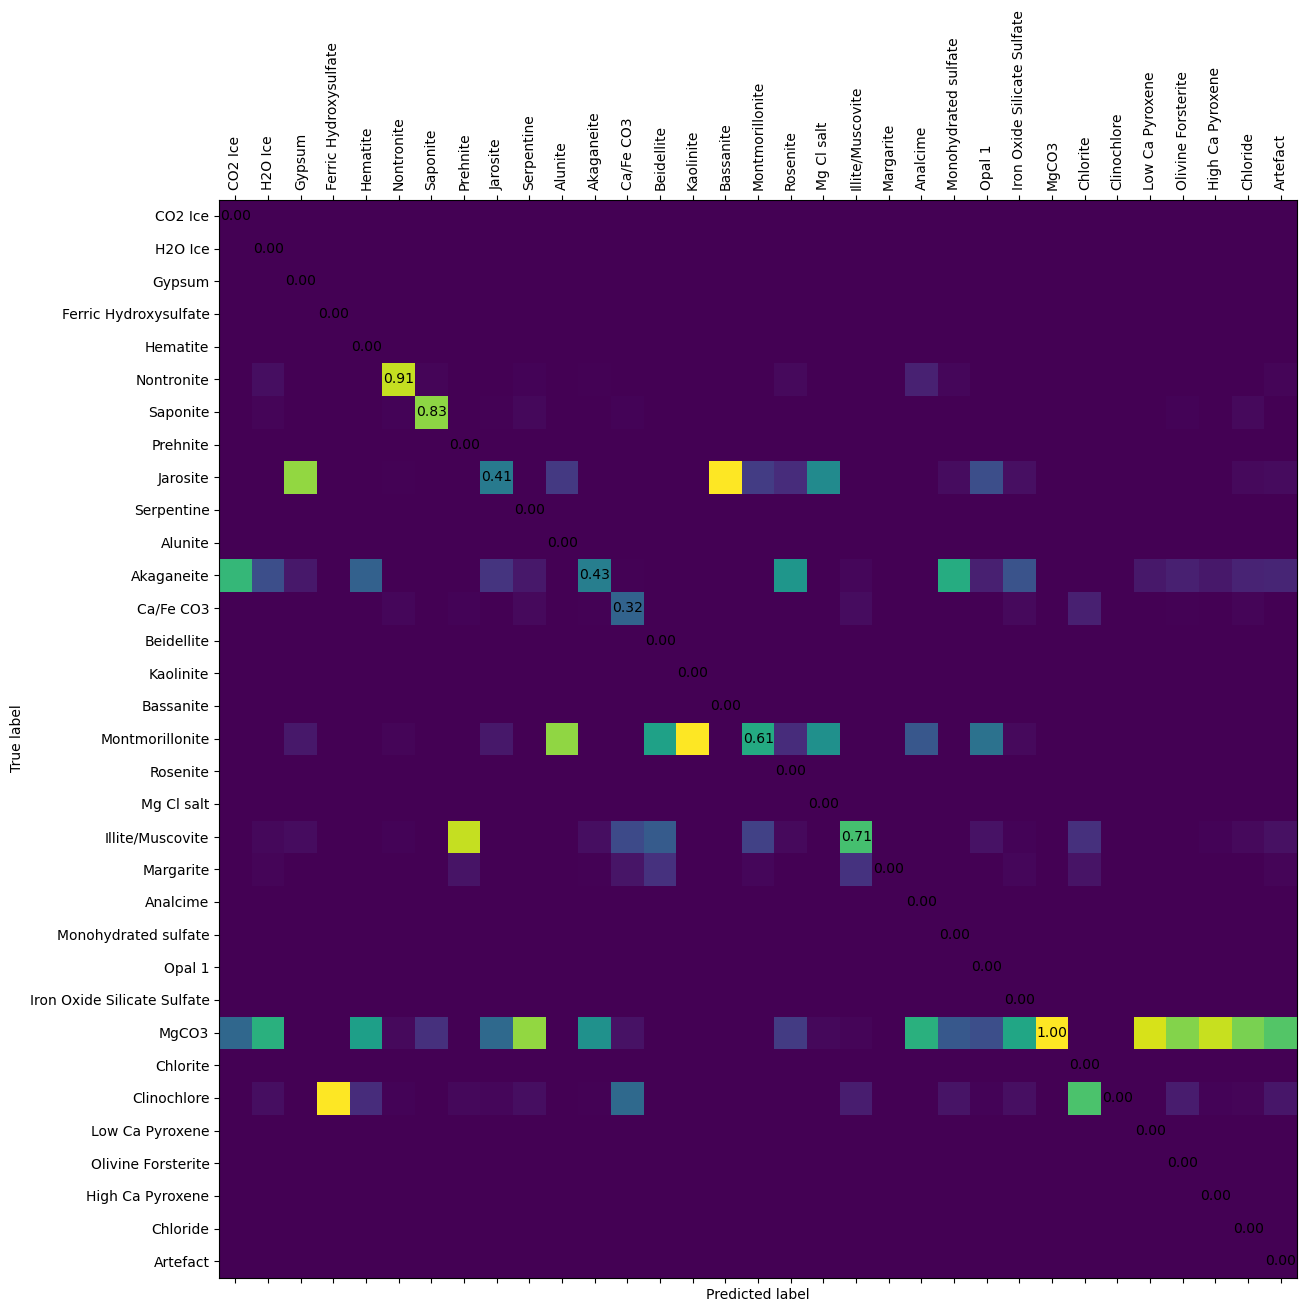

In [54]:
cm = confusion_matrix(holdout_labels, preds_zero_indexed, normalize="pred")

fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm)
# axes labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticks(range(len(string_labels)), string_labels, rotation=90)
ax.set_yticks(range(len(string_labels)), string_labels)
for i in range(len(string_labels)):
    for j in range(len(string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

Second time around, using only the classes the model was trained on (i.e. mapping some of the precise classes to broader labels)

In [55]:
# need to change the test_labels to match the plebani scheme if I want to use their relabelling.
holdout_labels_relabelled = labelling.change_pixel_label(holdout_labels.copy(), in_val=21, out_val=38)
holdout_labels_relabelled = labelling.make_array_zero_indexed(holdout_labels_relabelled, forwards=False, force=True) # need to force as doesn't contain every label

In [56]:
holdout_labels_relabelled = relabel(holdout_labels_relabelled, ALIASES_TRAIN)
filtered_holdout_labels_relabelled = holdout_labels_relabelled[filter_mask.mask]

In [57]:
report = get_classification_report(preds, holdout_labels_relabelled, CLASS_NAMES)
filtered_report = get_classification_report(filtered_preds, filtered_holdout_labels_relabelled, CLASS_NAMES)

In [58]:
# calculate EC
holdout_labels_relabelled_zero_indexed = labelling.make_array_zero_indexed(holdout_labels_relabelled, forwards=True)
preds_zero_indexed = labelling.make_array_zero_indexed(preds, forwards=True)

super_class_expected_cost = average_cost(holdout_labels_relabelled_zero_indexed, preds_zero_indexed, cost_matrix, priors)

In [59]:
print("For base predictions:")
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {super_class_expected_cost}")
print("For filtered predictions:")
print(f"Accuracy: {filtered_report['accuracy']}")
print(f"Macro F1: {filtered_report['macro avg']['f1-score']}")
print(f"Weighted F1: {filtered_report['weighted avg']['f1-score']}")
print(f"Precision: {filtered_report['macro avg']['precision']}")
print(f"Recall: {filtered_report['macro avg']['recall']}")

For base predictions:
Accuracy: 0.6869977889230438
Macro F1: 0.17875716302770853
Weighted F1: 0.7458126607100191
Precision: 0.19607371058411546
Recall: 0.17309826733515166
Expected Cost: 0.10028566394438446
For filtered predictions:
Accuracy: 0.9474274324155973
Macro F1: 0.5085736215188517
Weighted F1: 0.9477421509155113
Precision: 0.5466611035022694
Recall: 0.5006256351358052


In [60]:
unique_labels = np.unique(np.concatenate((np.unique(holdout_labels_relabelled), np.unique(preds))))
relabelled_string_labels = [CLASS_NAMES[obs_class] for obs_class in unique_labels]

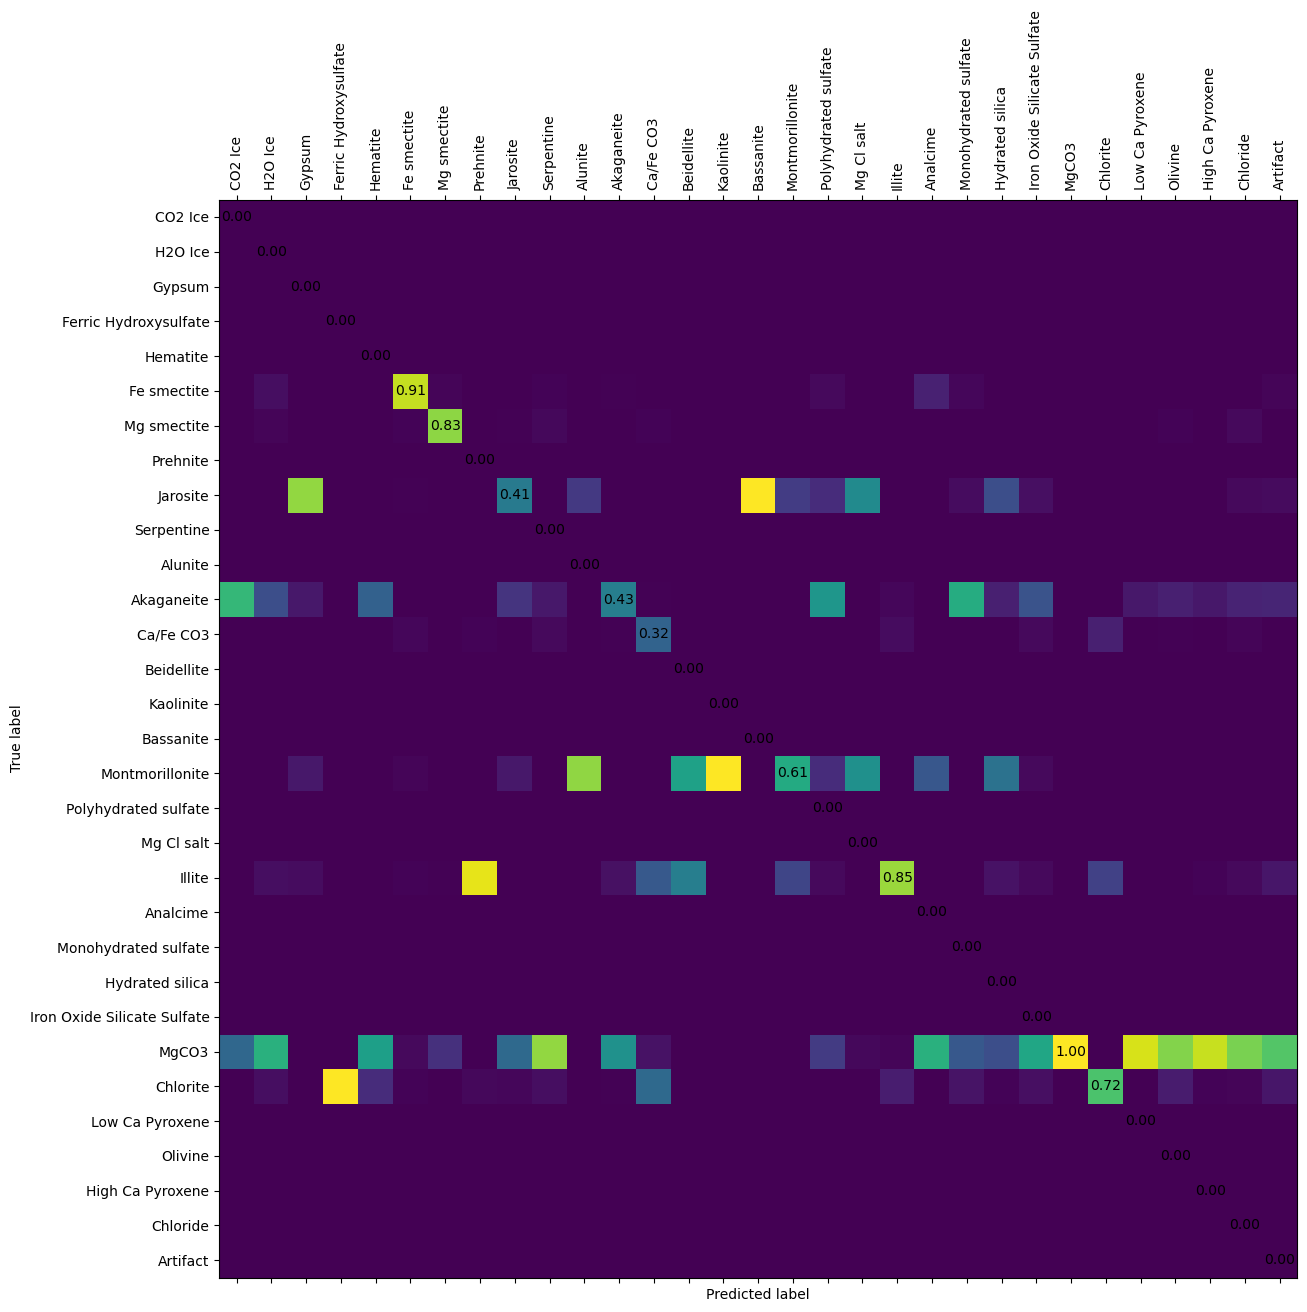

In [61]:
cm = confusion_matrix(holdout_labels_relabelled, preds, normalize="pred")

fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm)
# axes labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticks(range(len(relabelled_string_labels)), relabelled_string_labels, rotation=90)
ax.set_yticks(range(len(relabelled_string_labels)), relabelled_string_labels)
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(relabelled_string_labels)):
    for j in range(len(relabelled_string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")
plt.show()

Calibration

In [62]:
accuracies = preds == holdout_labels_relabelled
accuracies = torch.tensor(accuracies)
bin_bounds = torch.linspace(0, 1, 11) # ten bins
pred_probs = torch.tensor(pred_probs)
acc_bin, conf_bin, prop_bin = _binning_bucketize(pred_probs, accuracies, bin_bounds) # bucketize the probs/confs, the accuracies, and the proportion of data in each bin
# acc_bin gives the accuracy for each bin, conf_bin is the average confidence of the bin, and prop_bin is the proportion of data in each bin

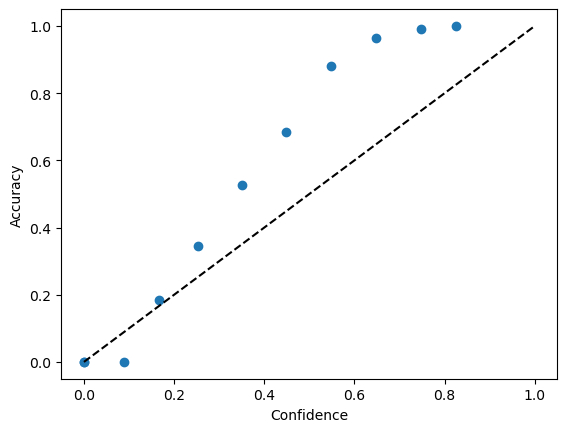

In [63]:
fig, ax = plt.subplots()
ax.scatter(conf_bin, acc_bin)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
# add a diagonal line for reference
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

In [64]:
conf_bin

tensor([0.0888, 0.1656, 0.2524, 0.3514, 0.4481, 0.5487, 0.6486, 0.7475, 0.8249,
        0.0000, 0.0000], dtype=torch.float64)

In [69]:
print(f"Mean confidnece: {pred_probs.mean()}, minimum confidence {pred_probs.min()}, maximum confidence {pred_probs.max()}")

Mean confidnece: 0.47097347461865263, minimum confidence 0.07906758718316018, maximum confidence 0.8929499954619229


In [70]:
holdout_scores = torch.tensor(holdout_scores)
holdout_labels_relabelled = torch.tensor(holdout_labels_relabelled)

In [71]:
calibration_metric = MulticlassCalibrationError(num_classes=32, n_bins=10)
calibration_metric.update(holdout_scores, holdout_labels_relabelled)
ece = calibration_metric.compute()
print(f"ECE: {ece}")

ECE: 0.4655325412750244
